# Imports and function definitions

Для начало импортируем необходимые библиотеки:
Задается путем введение на консоле "pip install " + необходимые пакеты. Для jupiter notebook задается здесь
Например:
    !pip install tensorflow
    
Необходимые библиотеки:

    1 tensorflow - библиотека глубокого обучения
    
    2 tensorflow_hub - для работы с пред-обученными моделями
    
    3 matplotlib - графический иллюстратор
    
    4 tempfile - библиотека для временных файлов
    
    5 urlopen - работа в URL ссылкой
    
    6 BytesIO - работа с данными в памяти
    
    7 numpy - для поддержки математических функции
    
    8 PIL - для работы с растровой графикой
    
    9 time - таймер реального времени
    

In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

# Import computer vision library
import cv2 as cv
import os

2.8.0
The following GPU devices are available: 


# Helper functions for downloading images and for visualization.

Здесь прописаны функции для визуалицации и предварительной обработки изображения.

In [10]:
# Display image function
def display_image(image):
  fig = plt.figure(figsize=(15, 10))
  plt.grid(False)
  plt.imshow(image)

# Downlowad and resize. Work only for .jpg files!
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)
  print('Box coordinates: ', int(left), int(right), int(top), int(bottom))
  #cropped = image[50:100, 80:280]
  #plt.imshow(image)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  # Use default font type
  font = ImageFont.load_default()
  
  print("Founds: ")
  for i in range(min(boxes.shape[0], max_boxes)):
    # Print all possible classes found
    print(class_names[i])
    # Drawing boxes if it is 'Human face'
    if class_names[i] == b'Human face': 
        if scores[i] >= min_score:
          ymin, xmin, ymax, xmax = tuple(boxes[i])
          display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
          color = colors[hash(class_names[i]) % len(colors)]
          image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
          draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])          
          #print(ymin, xmin, ymax, xmax)
          np.copyto(image, np.array(image_pil))
  return image

# Apply module

Основная часть. С помощью tensorflow hub можно работать с пред-обученными нейросетями(Transfer learning), при этом не вдавая в архитектуры сетей.
Работает по принципу "черной коробки":

На входе - изображение с 3-мя каналами RGB:

    A three-channel image of variable size - the model does NOT support batching*. The input tensor is a tf.float32 tensor with shape [1, height, width, 3] with values in [0.0, 1.0].
    
На выходе - 100 найденных объектов из 600 объектов датасета:

    detection_boxes: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].
    
    detection_class_entities: a tf.string tensor of shape [N] containing detection class names as Freebase MIDs.
    
    detection_class_names: a tf.string tensor of shape [N] containing human-readable detection class names.
    
    detection_class_labels: a tf.int64 tensor of shape [N] with class indices.
    
    detection_scores: a tf.float32 tensor of shape [N] containing detection scores.
    
    

*batching - подача нескольких избражений одновременно за 1 эпох. Подача 100 изображений (28 x 28) за раз (вместо 1, как в случае онлайн-обучения), размер batching составляет 100.

*Все имеющиеся датасеты можно посмотреть десь: https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html   

In [3]:
# Loading pre-trained Model: FasterRCNN+InceptionResNet_V2
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
# loading function.
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3) #channels - Defaults to 0. Number of color channels for the decoded image.
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)
  ymin, xmin, ymax, xmax =  tuple(result["detection_boxes"][0])
  im_width, im_height, color_space = img.shape
  (left, right, top, bottom) = (xmin * im_height, xmax * im_height,
                                  ymin * im_width, ymax * im_width)
  if bottom-top > right-left:
    right=right+(bottom-top)-(right-left)
  else:
    bottom=bottom+(right-left)-(bottom-top)



  cropped = img[int(top):int(bottom), int(left):int(right)]
  grayed = cv.cvtColor(np.float32(cropped), cv.COLOR_RGB2GRAY)
  #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  display_image(image_with_boxes)
  return np.float32(cropped)

# URL from enternet
image_urls = [
    "https://live.staticflickr.com/65535/51328812673_27ad001a2c_h.jpg",
    "https://live.staticflickr.com/65535/50982978592_e778dde53f_h.jpg",
    "https://live.staticflickr.com/65535/50494786592_e3ea3a86e6_h.jpg"
    ]


In [5]:
grayed = np.zeros((1000,1000), np.uint8)

# Testing Samples

По предварительным датасетам, берем выборку 20 из 100 объектов. Рисуем bounding box, если присутсвует 'Human face'.

Далее, координаты bounding box подкорректируем в квадратную рамку, и обрезаем исходную картинку.
Получившиеся картинки мы вручную сохраняем в отдельные папки.

В нашем примере, в папке model, присутствует 4 классы. Папка model сохраняем как архив и приступить к задаче классификации портретов.
https://drive.google.com/file/d/130_8bj-fzLJZWADGuu_fGOTZL3S8TnEG/view?usp=sharing

START+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Image downloaded to /tmp/tmpdm10s3r4.jpg.
Found 100 objects.
Inference time:  62.590659618377686
Founds: 
b'Human face'
Top 170.84834575653076 249.66899871826172 126.19939804077148 209.24623489379883
0.19718656 0.35593405 0.32694724 0.52014375
b'Girl'
b'Clothing'
b'Human leg'
b'Woman'
b'Footwear'
b'Jacket'
b'Girl'
b'Woman'
b'Human hair'
END+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
START+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Image downloaded to /tmp/tmpkslrzvb9.jpg.
Found 100 objects.
Inference time:  31.1824152469635
Founds: 
b'Human face'
Top 171.85027599334717 327.59236335754395 177.5493049621582 346.0313415527344
0.2774208 0.3580214 0.540674 0.6824841
b'Scarf'
b'Scarf'
b'Scarf'
b'Clothing'
b'Girl'
b'Fashion accessory'
b'Fashion accessory'
b'Hat'
b'Human nose'
END++++++++++++++++++++++++++++++++++

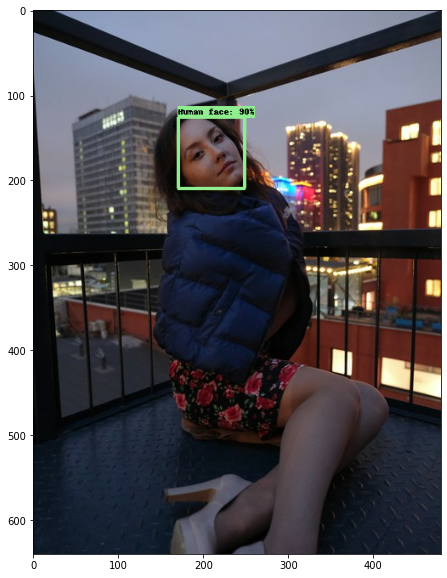

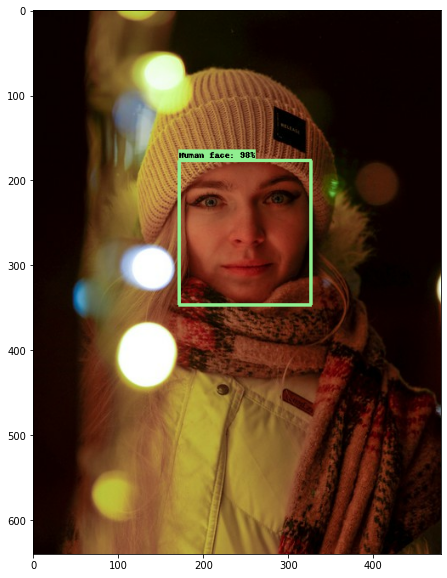

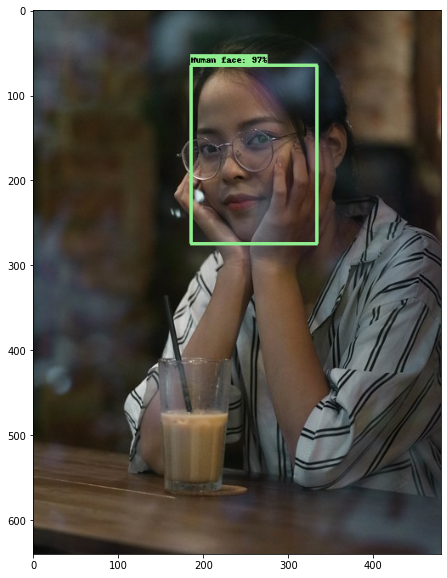

In [6]:
i=0
grayed = np.zeros((1000,1000), np.uint8)
start_time = time.time()
while i < len(image_urls):
  print('START+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
  image_path = download_and_resize_image(image_urls[i], 480, 640)
  img = run_detector(detector, image_path)
  matplotlib.image.imsave("Result " + str(i) + ".jpg", np.uint8(img))
  i=i+1
  print('END+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

end_time = time.time()
print("Inference time:",end_time-start_time)

This images are saved for image classification


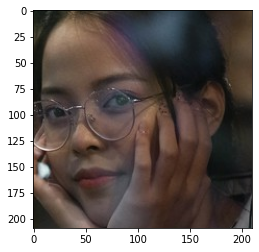

In [7]:
plt.imshow(np.int64(img))
matplotlib.image.imsave('name.jpg', np.uint8(img))
print('This images are saved for image classification')

# Conclutions

Fast RCNN дает относительно высокое скорость обработки. Но требует дополнительные улучшения. Среднее время обработки составляет 30 секунд, что очень много для системы разпознавания в "онлайн" режиме.

Для решения быстродейсвия можно решить нескольким путем:

1) замена на более простую модель вместо FasterRCNN+InceptionResNetV2 на ssd+mobilenetV2;

2) замена на более совершенную архитектуру YOLOv4;

3) квантизация нейросети: замена число с плавающей точкой на целые числа;

4) подключить аппаратное ускорение такие как параллельное вычисление и подключение графических карт.
